In [1]:

from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [2]:
import numpy as np
import h5py
import math

from keras.models import Model
from keras.layers import Input, Activation, BatchNormalization, Conv2D, Conv3D
from keras.layers import Lambda, Concatenate, MaxPooling2D, Maximum, Add
from keras.initializers import RandomNormal
from keras.optimizers import SGD
from keras.losses import MeanSquaredError
from keras.callbacks import Callback,LearningRateScheduler
from keras.utils import plot_model

import keras.backend as K
K.set_image_data_format('channels_last')

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline

In [3]:
extract_path = '/content/train-20240529T055154Z-001.zip'


In [5]:
import os
input_dir = os.path.join(extract_path, 'train', 'input')
target_dir = os.path.join(extract_path, 'train', 'target')


In [6]:
def load_images_from_directory(directory):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(directory, filename)
            img = load_img(img_path)
            img_array = img_to_array(img)
            images.append(img_array)
    return np.array(images)


In [7]:
import zipfile
import os

# Path to the ZIP file
zip_file_path = '/content/drive/MyDrive/train.zip'

# Directory to extract to
extract_dir = '/content/train-20240529T055154Z-001'

# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Check the contents of the extraction directory
print(os.listdir(extract_dir))


['train']


In [8]:
import numpy as np
from keras.initializers import RandomNormal

# Function to generate dummy data
def generate_dummy_data():
    clean_image = np.random.rand(100, 16, 16, 3)  # Example shape: (100, 16, 16, 3)
    haze_image = np.random.rand(100, 16, 16, 3)   # Example shape: (100, 16, 16, 3)
    transmission_map = np.random.rand(100, 16, 16)  # Example shape: (100, 16, 16)
    transmission_map_refine = np.random.rand(100, 16, 16)  # Example shape: (100, 16, 16)

    return clean_image, haze_image, transmission_map, transmission_map_refine

# Gaussian Weight Initialization for layers
weight_init = RandomNormal(mean=0.0, stddev=0.001)

# Learning Rate Decay function
def lr_schedule(epoch, lr, logs={}):
    """
    Learning Rate Decay scheduler

    Arguments:
    epoch -- current epoch number
    lr -- current learning rate
    logs -- dictionary storing the logs of training

    Returns:
    lr -- learning rate for the next epoch
    """
    print('Learning Rate:', lr)
    logs.update({'lr': lr})

    if epoch in (49, 99):
        return lr * 0.5
    else:
        return lr

# Example usage
clean_image, haze_image, transmission_map, transmission_map_refine = generate_dummy_data()

# Print the shapes of loaded data (example)
print(f"Clean Image Shape: {clean_image.shape}")
print(f"Haze Image Shape: {haze_image.shape}")
print(f"Transmission Map Shape: {transmission_map.shape}")
print(f"Transmission Map Refine Shape: {transmission_map_refine.shape}")


Clean Image Shape: (100, 16, 16, 3)
Haze Image Shape: (100, 16, 16, 3)
Transmission Map Shape: (100, 16, 16)
Transmission Map Refine Shape: (100, 16, 16)


In [ ]:
import os
import numpy as np
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Paths to the input and target directories
input_dir = '/content/train-20240529T055154Z-001/train/input'
target_dir = '/content/train-20240529T055154Z-001/train/target'

# Function to load images from a directory
def load_images_from_directory(directory):
    """
    Load images from a given directory

    Arguments:
    directory -- Path to the directory containing images

    Returns:
    images -- List of images as numpy arrays
    """
    images = []
    for filename in os.listdir(directory):
        if filename.endswith(('.png', '.jpg', '.jpeg')):  # Add more extensions if needed
            img_path = os.path.join(directory, filename)
            img = load_img(img_path)  # Load the image
            img_array = img_to_array(img)  # Convert image to numpy array
            images.append(img_array)
    return np.array(images)

# Load datasets
clean_images = load_images_from_directory(input_dir)
hazy_images = load_images_from_directory(target_dir)

# Print shapes of the loaded datasets
print("Clean Image Shape:", clean_images.shape)
print("Hazy Image Shape:", hazy_images.shape)

# Gaussian Weight Initialization for layers
weight_init = RandomNormal(mean=0.0, stddev=0.001)

# LearningRate Decay function
def lr_schedule(epoch, lr, logs={}):
    """
    Learning Rate Decay scheduler

    Arguments:
    epoch -- current epoch number
    lr -- current learning rate
    logs -- dictionary storing the logs of training

    Returns:
    lr -- learning rate for next epoch
    """

    print('learning_rate:', lr)
    logs.update({'lr': lr})
    if epoch in (49, 99):
        return lr * 0.5
    else:
        return lr

# Example usage:
print("Clean Image Shape:", clean_images.shape)
print("Hazy Image Shape:", hazy_images.shape)


In [ ]:
import os
import numpy as np
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Paths to the input and target directories
input_dir = '/content/train-20240529T055154Z-001/train/input'
target_dir = '/content/train-20240529T055154Z-001/train/target'

# Function to load images from a directory
def load_images_from_directory(directory):
    """
    Load images from a given directory

    Arguments:
    directory -- Path to the directory containing images

    Returns:
    images -- List of images as numpy arrays
    """
    images = []
    for filename in os.listdir(directory):
        if filename.endswith(('.png', '.jpg', '.jpeg')):  # Add more extensions if needed
            img_path = os.path.join(directory, filename)
            img = load_img(img_path)  # Load the image
            img_array = img_to_array(img)  # Convert image to numpy array
            images.append(img_array)
    return np.array(images)

# Load datasets
clean_images = load_images_from_directory(input_dir)
hazy_images = load_images_from_directory(target_dir)

# Mock transmission map and refine map since we're not loading it from HDF5
# You might need to adjust this part depending on your actual dataset
num_examples = min(clean_images.shape[0], hazy_images.shape[0])
transmission_map = np.ones((num_examples, 16, 16, 1))  # Example shape
transmission_map_refine = np.ones((num_examples, 16, 16, 1))  # Example shape

# Print shapes of the loaded datasets
print("Number of training examples:", num_examples)
print("Clean Image Patch shape:", clean_images.shape)
print("Haze Image Patch shape:", hazy_images.shape)
print("Transmission Map shape:", transmission_map.shape)
print("Transmission Map Refine shape:", transmission_map_refine.shape)

# Gaussian Weight Initialization for layers
weight_init = RandomNormal(mean=0.0, stddev=0.001)

# LearningRate Decay function
def lr_schedule(epoch, lr, logs={}):
    """
    Learning Rate Decay scheduler

    Arguments:
    epoch -- current epoch number
    lr -- current learning rate
    logs -- dictionary storing the logs of training

    Returns:
    lr -- learning rate for next epoch
    """

    print('learning_rate:', lr)
    logs.update({'lr': lr})
    if epoch in (49, 99):
        return lr * 0.5
    else:
        return lr

# Example usage:
print("Clean Image Shape:", clean_images.shape)
print("Hazy Image Shape:", hazy_images.shape)


In [1]:
import os
import numpy as np
import cv2  # You may need to install OpenCV: pip install opencv-python

def load_dataset(directory_path):
    """
    Load training dataset from directory containing image patches

    Arguments:
    directory_path -- Path to the directory containing image patches

    Returns:
    clean_image -- List of clean image patches
    haze_image -- List of haze image patches
    transmission_map -- List of transmission maps
    transmission_map_refine -- List of refined transmission maps
    """
    clean_image = []
    haze_image = []
    transmission_map = []
    transmission_map_refine = []

    for file_name in os.listdir(directory_path):
        file_path = os.path.join(directory_path, file_name)

        if file_name.startswith('clean_image'):
            img = cv2.imread(file_path)
            clean_image.append(img)
        elif file_name.startswith('haze_image'):
            img = cv2.imread(file_path)
            haze_image.append(img)
        elif file_name.startswith('transmission_map'):
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            transmission_map.append(img)
        elif file_name.startswith('transmission_map_refine'):
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            transmission_map_refine.append(img)

    return clean_image, haze_image, transmission_map, transmission_map_refine

# Example usage
directory_path = '/content/train-20240529T055154Z-001'

clean_image, haze_image, transmission_map, transmission_map_refine = load_dataset(directory_path)

# Convert lists to numpy arrays
clean_image = np.array(clean_image)
haze_image = np.array(haze_image)
transmission_map = np.array(transmission_map)
transmission_map_refine = np.array(transmission_map_refine)

# Print the shapes of loaded data (example)
print(f"Clean Image Shape: {clean_image.shape}")
print(f"Haze Image Shape: {haze_image.shape}")
print(f"Transmission Map Shape: {transmission_map.shape}")
print(f"Transmission Map Refine Shape: {transmission_map_refine.shape}")


Clean Image Shape: (0,)
Haze Image Shape: (0,)
Transmission Map Shape: (0,)
Transmission Map Refine Shape: (0,)


In [2]:
import os

# Directory path
directory_path = '/content/train-20240529T055154Z-001/train'

# List files in the directory
print(f"Contents of directory: {directory_path}")
print("=========================================")

for file_name in os.listdir(directory_path):
    file_path = os.path.join(directory_path, file_name)
    print(file_path)

print("=========================================")


Contents of directory: /content/train-20240529T055154Z-001/train
/content/train-20240529T055154Z-001/train/target
/content/train-20240529T055154Z-001/train/input


In [3]:
import os
import numpy as np
import cv2  # Make sure to install OpenCV: pip install opencv-python

def load_dataset(directory_path):
    """
    Load training dataset from directory containing image patches

    Arguments:
    directory_path -- Path to the directory containing image patches

    Returns:
    clean_image -- List of clean image patches
    haze_image -- List of haze image patches
    transmission_map -- List of transmission maps
    transmission_map_refine -- List of refined transmission maps
    """
    clean_image = []
    haze_image = []
    transmission_map = []
    transmission_map_refine = []

    input_dir = os.path.join(directory_path, 'input')
    target_dir = os.path.join(directory_path, 'target')

    print(f"Loading dataset from directory: {directory_path}")
    print(f"Input directory: {input_dir}")
    print(f"Target directory: {target_dir}")

    # Check contents of input directory
    print(f"Contents of input directory: {os.listdir(input_dir)}")
    print(f"Contents of target directory: {os.listdir(target_dir)}")

    for file_name in os.listdir(input_dir):
        input_file_path = os.path.join(input_dir, file_name)
        target_file_path = os.path.join(target_dir, file_name)

        print(f"Processing file: {file_name}")
        print(f"Input file path: {input_file_path}")
        print(f"Target file path: {target_file_path}")

        if file_name.startswith('clean_image'):
            img_clean = cv2.imread(input_file_path)
            if img_clean is not None:
                clean_image.append(img_clean)
                print(f"Added clean_image: {file_name}")
            else:
                print(f"Unable to read clean_image: {input_file_path}")

        elif file_name.startswith('haze_image'):
            img_haze = cv2.imread(input_file_path)
            if img_haze is not None:
                haze_image.append(img_haze)
                print(f"Added haze_image: {file_name}")
            else:
                print(f"Unable to read haze_image: {input_file_path}")

        if file_name.startswith('transmission_map'):
            img_transmission = cv2.imread(target_file_path, cv2.IMREAD_GRAYSCALE)
            if img_transmission is not None:
                transmission_map.append(img_transmission)
                print(f"Added transmission_map: {file_name}")
            else:
                print(f"Unable to read transmission_map: {target_file_path}")

        elif file_name.startswith('transmission_map_refine'):
            img_transmission_refine = cv2.imread(target_file_path, cv2.IMREAD_GRAYSCALE)
            if img_transmission_refine is not None:
                transmission_map_refine.append(img_transmission_refine)
                print(f"Added transmission_map_refine: {file_name}")
            else:
                print(f"Unable to read transmission_map_refine: {target_file_path}")

    return clean_image, haze_image, transmission_map, transmission_map_refine

# Example usage
directory_path = '/content/train-20240529T055154Z-001/train'

clean_image, haze_image, transmission_map, transmission_map_refine = load_dataset(directory_path)

# Convert lists to numpy arrays
clean_image = np.array(clean_image)
haze_image = np.array(haze_image)
transmission_map = np.array(transmission_map)
transmission_map_refine = np.array(transmission_map_refine)

# Print the shapes of loaded data
print(f"Number of training examples: {clean_image.shape[0]}")
print(f"Clean Image Patch shape: {clean_image.shape}")
print(f"Haze Image Patch shape: {haze_image.shape}")
print(f"Transmission Map shape: {transmission_map.shape}")
print(f"Transmission Map Refine shape: {transmission_map_refine.shape}")


Streaming output truncated to the last 5000 lines.
Processing file: 13188.jpg
Input file path: /content/train-20240529T055154Z-001/train/input/13188.jpg
Target file path: /content/train-20240529T055154Z-001/train/target/13188.jpg
Processing file: 1537.jpg
Input file path: /content/train-20240529T055154Z-001/train/input/1537.jpg
Target file path: /content/train-20240529T055154Z-001/train/target/1537.jpg
Processing file: 9036.jpg
Input file path: /content/train-20240529T055154Z-001/train/input/9036.jpg
Target file path: /content/train-20240529T055154Z-001/train/target/9036.jpg
Processing file: 9241.jpg
Input file path: /content/train-20240529T055154Z-001/train/input/9241.jpg
Target file path: /content/train-20240529T055154Z-001/train/target/9241.jpg
Processing file: 3380.jpg
Input file path: /content/train-20240529T055154Z-001/train/input/3380.jpg
Target file path: /content/train-20240529T055154Z-001/train/target/3380.jpg
Processing file: 4366.jpg
Input file path: /content/train-20240529

In [4]:
pip install opencv-python

In [5]:
import os
import numpy as np
import cv2  # You may need to install OpenCV: pip install opencv-python

def load_train_dataset():
    """
    Load training dataset from the directory containing image patches.

    Returns:
    clean_image -- Clean image patches
    haze_image -- Haze image patches
    transmission_map -- Transmission maps
    transmission_map_refine -- Refined transmission maps
    """
    clean_image = []
    haze_image = []
    transmission_map = []
    transmission_map_refine = []

    directory_path = '/content/train-20240529T055154Z-001/train'
    input_dir = os.path.join(directory_path, 'input')
    target_dir = os.path.join(directory_path, 'target')

    print(f"Loading dataset from directory: {directory_path}")
    print(f"Input directory: {input_dir}")
    print(f"Target directory: {target_dir}")

    # Load clean and haze images from input directory
    for file_name in os.listdir(input_dir):
        img_path = os.path.join(input_dir, file_name)
        if file_name.endswith(('.png', '.jpg', '.jpeg')):  # Adjust extensions as needed
            img = cv2.imread(img_path)
            if img is not None:
                img_resized = cv2.resize(img, (16, 16))  # Resize image to 16x16
                clean_image.append(img_resized)
                haze_image.append(img_resized)  # Assuming haze images are the same as clean images
            else:
                print(f"Unable to read image: {img_path}")
        else:
            print(f"Skipping file: {file_name} (not a supported image format)")

    # Load transmission maps and refine maps from target directory
    for file_name in os.listdir(target_dir):
        img_path = os.path.join(target_dir, file_name)
        if file_name.startswith('transmission_map'):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img_resized = cv2.resize(img, (16, 16))  # Resize transmission map to 16x16
                transmission_map.append(img_resized)
            else:
                print(f"Unable to read transmission map: {img_path}")
        elif file_name.startswith('transmission_map_refine'):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img_resized = cv2.resize(img, (16, 16))  # Resize refined transmission map to 16x16
                transmission_map_refine.append(img_resized)
            else:
                print(f"Unable to read transmission map refine: {img_path}")

    # Convert lists to numpy arrays
    clean_image = np.array(clean_image)
    haze_image = np.array(haze_image)
    transmission_map = np.array(transmission_map)
    transmission_map_refine = np.array(transmission_map_refine)

    # Ensure the arrays have the expected dimensions
    if len(clean_image) > 0:
        clean_image = clean_image.reshape(-1, 16, 16, 3)
    if len(haze_image) > 0:
        haze_image = haze_image.reshape(-1, 16, 16, 3)
    if len(transmission_map) > 0:
        transmission_map = transmission_map.reshape(-1, 16, 16, 1)
    if len(transmission_map_refine) > 0:
        transmission_map_refine = transmission_map_refine.reshape(-1, 16, 16, 1)

    return clean_image, haze_image, transmission_map, transmission_map_refine

# Example usage
clean_image, haze_image, transmission_map, transmission_map_refine = load_train_dataset()

# Print the shapes of loaded data
print(f"Number of training examples: {clean_image.shape[0]}")
print(f"Clean Image Patch shape: {clean_image.shape}")
print(f"Haze Image Patch shape: {haze_image.shape}")
print(f"Transmission Map shape: {transmission_map.shape}")
print(f"Transmission Map Refine shape: {transmission_map_refine.shape}")


Loading dataset from directory: /content/train-20240529T055154Z-001/train
Input directory: /content/train-20240529T055154Z-001/train/input
Target directory: /content/train-20240529T055154Z-001/train/target
Number of training examples: 13711
Clean Image Patch shape: (13711, 16, 16, 3)
Haze Image Patch shape: (13711, 16, 16, 3)
Transmission Map shape: (0,)
Transmission Map Refine shape: (0,)


In [ ]:
import os
import numpy as np
import cv2  # You may need to install OpenCV: pip install opencv-python

def load_train_dataset():
    """
    Load training dataset from the directory containing image patches.

    Returns:
    clean_image -- Clean image patches
    haze_image -- Haze image patches
    transmission_map -- Transmission maps (empty if not present)
    transmission_map_refine -- Refined transmission maps (empty if not present)
    """
    clean_image = []
    haze_image = []

    directory_path = '/content/train-20240529T055154Z-001/train'
    input_dir = os.path.join(directory_path, 'input')
    target_dir = os.path.join(directory_path, 'target')

    print(f"Loading dataset from directory: {directory_path}")
    print(f"Input directory: {input_dir}")
    print(f"Target directory: {target_dir}")

    # Load clean and haze images from input directory
    for file_name in os.listdir(input_dir):
        img_path = os.path.join(input_dir, file_name)
        if file_name.endswith(('.png', '.jpg', '.jpeg')):  # Adjust extensions as needed
            img = cv2.imread(img_path)
            if img is not None:
                img_resized = cv2.resize(img, (16, 16))  # Resize image to 16x16
                clean_image.append(img_resized)
            else:
                print(f"Unable to read image: {img_path}")
        else:
            print(f"Skipping file: {file_name} (not a supported image format)")

    # Load haze images from target directory
    for file_name in os.listdir(target_dir):
        img_path = os.path.join(target_dir, file_name)
        if file_name.endswith(('.png', '.jpg', '.jpeg')):  # Adjust extensions as needed
            img = cv2.imread(img_path)
            if img is not None:
                img_resized = cv2.resize(img, (16, 16))  # Resize image to 16x16
                haze_image.append(img_resized)
            else:
                print(f"Unable to read image: {img_path}")
        else:
            print(f"Skipping file: {file_name} (not a supported image format)")

    # Convert lists to numpy arrays
    clean_image = np.array(clean_image)
    haze_image = np.array(haze_image)

    # Ensure the arrays have the expected dimensions
    if len(clean_image) > 0:
        clean_image = clean_image.reshape(-1, 16, 16, 3)
    if len(haze_image) > 0:
        haze_image = haze_image.reshape(-1, 16, 16, 3)

    return clean_image, haze_image, np.array([]), np.array([])  # Empty arrays for transmission maps

# Example usage
clean_image, haze_image, transmission_map, transmission_map_refine = load_train_dataset()

# Print the shapes of loaded data
print(f"Number of training examples: {clean_image.shape[0]}")
print(f"Clean Image Patch shape: {clean_image.shape}")
print(f"Haze Image Patch shape: {haze_image.shape}")
print(f"Transmission Map shape: {transmission_map.shape}")
print(f"Transmission Map Refine shape: {transmission_map_refine.shape}")


Loading dataset from directory: /content/train-20240529T055154Z-001/train
Input directory: /content/train-20240529T055154Z-001/train/input
Target directory: /content/train-20240529T055154Z-001/train/target
Number of training examples: 13711
Clean Image Patch shape: (13711, 16, 16, 3)
Haze Image Patch shape: (13711, 16, 16, 3)
Transmission Map shape: (0,)
Transmission Map Refine shape: (0,)


In [ ]:
import os
import numpy as np
import cv2  # You may need to install OpenCV: pip install opencv-python

def load_train_dataset():
    """
    Load training dataset from the directory containing image patches.

    Returns:
    clean_image -- Clean image patches
    haze_image -- Haze image patches
    """
    clean_image = []
    haze_image = []

    directory_path = '/content/train-20240529T055154Z-001/train'
    input_dir = os.path.join(directory_path, 'input')
    target_dir = os.path.join(directory_path, 'target')

    print(f"Loading dataset from directory: {directory_path}")
    print(f"Input directory: {input_dir}")
    print(f"Target directory: {target_dir}")

    # Load clean images from input directory
    for file_name in os.listdir(input_dir):
        img_path = os.path.join(input_dir, file_name)
        if file_name.endswith(('.png', '.jpg', '.jpeg')):  # Adjust extensions as needed
            img = cv2.imread(img_path)
            if img is not None:
                img_resized = cv2.resize(img, (16, 16))  # Resize image to 16x16
                clean_image.append(img_resized)
            else:
                print(f"Unable to read image: {img_path}")
        else:
            print(f"Skipping file: {file_name} (not a supported image format)")

    # Load haze images from target directory
    for file_name in os.listdir(target_dir):
        img_path = os.path.join(target_dir, file_name)
        if file_name.endswith(('.png', '.jpg', '.jpeg')):  # Adjust extensions as needed
            img = cv2.imread(img_path)
            if img is not None:
                img_resized = cv2.resize(img, (16, 16))  # Resize image to 16x16
                haze_image.append(img_resized)
            else:
                print(f"Unable to read image: {img_path}")
        else:
            print(f"Skipping file: {file_name} (not a supported image format)")

    # Convert lists to numpy arrays
    clean_image = np.array(clean_image)
    haze_image = np.array(haze_image)

    # Ensure the arrays have the expected dimensions
    if len(clean_image) > 0:
        clean_image = clean_image.reshape(-1, 16, 16, 3)
    if len(haze_image) > 0:
        haze_image = haze_image.reshape(-1, 16, 16, 3)

    return clean_image, haze_image

# Example usage
clean_image, haze_image = load_train_dataset()

# Create dummy transmission maps
transmission_map_refine = np.ones((clean_image.shape[0], 16, 16, 1))  # All values set to 1

# Print shapes to verify
print(f"Number of training examples: {clean_image.shape[0]}")
print(f"Clean Image Patch shape: {clean_image.shape}")
print(f"Haze Image Patch shape: {haze_image.shape}")
print(f"Transmission Map Refine shape: {transmission_map_refine.shape}")

# Calculate residual input using dummy transmission maps
residual_input = np.clip((haze_image / 255.0) / transmission_map_refine, 0, 1)
residual_output = np.clip(residual_input - clean_image / 255.0, 0, 1)

# Print some values to verify
print(f"Residual Input Shape: {residual_input.shape}")
print(f"Residual Output Shape: {residual_output.shape}")


Loading dataset from directory: /content/train-20240529T055154Z-001/train
Input directory: /content/train-20240529T055154Z-001/train/input
Target directory: /content/train-20240529T055154Z-001/train/target
Number of training examples: 13711
Clean Image Patch shape: (13711, 16, 16, 3)
Haze Image Patch shape: (13711, 16, 16, 3)
Transmission Map Refine shape: (13711, 16, 16, 1)
Residual Input Shape: (13711, 16, 16, 3)
Residual Output Shape: (13711, 16, 16, 3)


In [6]:
import os
import numpy as np
import cv2  # You may need to install OpenCV: pip install opencv-python

def load_train_dataset():
    """
    Load training dataset from the directory containing image patches.

    Returns:
    clean_image -- Clean image patches
    haze_image -- Haze image patches
    transmission_map_refine -- Dummy transmission maps
    """
    clean_image = []
    haze_image = []

    directory_path = '/content/train-20240529T055154Z-001/train'
    input_dir = os.path.join(directory_path, 'input')
    target_dir = os.path.join(directory_path, 'target')

    print(f"Loading dataset from directory: {directory_path}")
    print(f"Input directory: {input_dir}")
    print(f"Target directory: {target_dir}")

    # Load clean images from input directory
    for file_name in os.listdir(input_dir):
        img_path = os.path.join(input_dir, file_name)
        if file_name.endswith(('.png', '.jpg', '.jpeg')):  # Adjust extensions as needed
            img = cv2.imread(img_path)
            if img is not None:
                img_resized = cv2.resize(img, (16, 16))  # Resize image to 16x16
                clean_image.append(img_resized)
            else:
                print(f"Unable to read image: {img_path}")
        else:
            print(f"Skipping file: {file_name} (not a supported image format)")

    # Load haze images from target directory
    for file_name in os.listdir(target_dir):
        img_path = os.path.join(target_dir, file_name)
        if file_name.endswith(('.png', '.jpg', '.jpeg')):  # Adjust extensions as needed
            img = cv2.imread(img_path)
            if img is not None:
                img_resized = cv2.resize(img, (16, 16))  # Resize image to 16x16
                haze_image.append(img_resized)
            else:
                print(f"Unable to read image: {img_path}")
        else:
            print(f"Skipping file: {file_name} (not a supported image format)")

    # Convert lists to numpy arrays
    clean_image = np.array(clean_image)
    haze_image = np.array(haze_image)

    # Ensure the arrays have the expected dimensions
    if len(clean_image) > 0:
        clean_image = clean_image.reshape(-1, 16, 16, 3)
    if len(haze_image) > 0:
        haze_image = haze_image.reshape(-1, 16, 16, 3)

    # Create dummy transmission maps
    transmission_map_refine = np.ones((clean_image.shape[0], 16, 16, 1))  # All values set to 1

    return clean_image, haze_image, transmission_map_refine

# Example usage
clean_image, haze_image, transmission_map_refine = load_train_dataset()

# Print shapes to verify
print(f"Number of training examples: {clean_image.shape[0]}")
print(f"Clean Image Patch shape: {clean_image.shape}")
print(f"Haze Image Patch shape: {haze_image.shape}")
print(f"Transmission Map Refine shape: {transmission_map_refine.shape}")

# Calculate residual input
residual_input = np.clip((haze_image / 255.0) / transmission_map_refine, 0, 1)
residual_output = np.clip(residual_input - clean_image / 255.0, 0, 1)

# Calculate the required metrics
mean_residual_input = np.mean(residual_input)
max_residual_input = np.max(residual_input)
min_residual_input = np.min(residual_input)
max_residual_output = np.max(residual_output)

print("Mean Residual Input:", mean_residual_input)
print("Max Residual Input:", max_residual_input)
print("Min Residual Input:", min_residual_input)
print("Max Residual Output:", max_residual_output)
print("Desired Output:", (mean_residual_input, max_residual_input, min_residual_input, max_residual_output))


Loading dataset from directory: /content/train-20240529T055154Z-001/train
Input directory: /content/train-20240529T055154Z-001/train/input
Target directory: /content/train-20240529T055154Z-001/train/target
Number of training examples: 13711
Clean Image Patch shape: (13711, 16, 16, 3)
Haze Image Patch shape: (13711, 16, 16, 3)
Transmission Map Refine shape: (13711, 16, 16, 1)
Mean Residual Input: 0.42317940758767625
Max Residual Input: 1.0
Min Residual Input: 0.0
Max Residual Output: 0.5019607843137255
Desired Output: (0.42317940758767625, 1.0, 0.0, 0.5019607843137255)


In [7]:
def ResidualBlock(X, iter):
    """
    Implementation of the single block of RNN

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    iter -- integer, used to name layers, depending on current residual block

    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """

    # Save the input value
    X_shortcut = X

    # BATCHNORMALIZATION -> CONV Block
    X = BatchNormalization(axis = 3, name = 'res_batchnorm_' + str(iter))(X)
    X = Conv2D(1, (3, 3), strides = (1,1), padding = 'same', kernel_initializer = weight_init, name = 'res_conv_' + str(iter))(X)

    # Add shortcut value to main path, and pass it through a RELU activation
    X = Add(name = 'res_add_'+ str(iter))([X,X_shortcut])
    X = Activation('relu', name = 'res_activation_'+ str(iter))(X)

    return X

def ResidualModel(input_shape):
    """
    Implementation of the Model.

    Arguments:
    input_shape -- shape of the images of the dataset
                   (height, width, channels) as a tuple.

    Returns:
    model -- a Model() instance in Keras
    """

    X_input = Input(input_shape, name = 'input1')

    # CONV -> RELU Block applied to X
    X = Conv2D(16, (3, 3), strides = (1, 1), padding = 'same', kernel_initializer = weight_init, name = 'conv1')(X_input)
    X = Activation('relu', name = 'activation1')(X)

    # X = Conv2D(8, (1, 1), kernel_initializer = weight_init, name='test_conv')(X)

    for i in range(17):
        X = ResidualBlock(X, i)

    # CONV BLock
    X = Conv2D(3, (3, 3), strides = (1, 1), padding = 'same', kernel_initializer = weight_init, name = 'conv2')(X)
    X = Activation('relu', name = 'activation2')(X)

    # Create Keras model instance
    model = Model(inputs = X_input, outputs = X, name='TransmissionModel')

    return model

In [8]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.initializers import RandomNormal


In [9]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.initializers import RandomNormal

def ResidualModel(input_shape):
    """
    Implementation of the ResidualModel.

    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """

    # Define weight initializer
    weight_init = RandomNormal(mean=0.0, stddev=0.001)

    X_input = Input(input_shape, name='input1')

    # CONV -> RELU Block applied to X
    X = Conv2D(16, (3, 3), strides=(1, 1), padding='same', kernel_initializer=weight_init, name='conv1')(X_input)
    X = Activation('relu', name='activation1')(X)

    # Third conv layer
    X = Conv2D(filters=3, kernel_size=(3, 3), strides=(1, 1), padding='same', name='conv2')(X)

    # Add shortcut value to the main path
    X = Add()([X, X_input])

    # Create model
    model = Model(inputs=X_input, outputs=X, name='ResidualModel')

    return model

# Assuming residual_input has been defined previously in your code
# Example of residual_input shape
residual_input_shape = (16, 16, 3)  # Replace with actual shape if different

# Instantiate and compile the model
model2 = ResidualModel(residual_input_shape)
model2.build(residual_input_shape)  # Build the model with the correct input shape
model2.compile(optimizer=SGD(0.001), loss=MeanSquaredError())

# Print model summary
model2.summary()


Model: "ResidualModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input1 (InputLayer)       │ (None, 16, 16, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1 (Conv2D)            │ (None, 16, 16, 16)     │            448 │ input1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation1 (Activation)  │ (None, 16, 16, 16)     │              0 │ conv1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2 (Conv2D)            │ (None, 16, 16, 3)      │            435 │ activation1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 16, 16, 3)      │              0 │ conv2[0][0],           │
│                           │                        │                │ input1[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 883 (3.45 KB)

 Trainable params: 883 (3.45 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add

def ResidualModel(input_shape):
    """
    Implementation of the ResidualModel.

    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """

    X_input = Input(input_shape, name='input1')

    # First convolution block
    X = Conv2D(16, (3, 3), strides=(1, 1), padding='same', name='conv1')(X_input)
    X = Activation('relu', name='activation1')(X)
    X = BatchNormalization(name='res_batchnorm_0')(X)
    X_res = Conv2D(1, (3, 3), strides=(1, 1), padding='same', name='res_conv_0')(X)
    X = Add(name='res_add_0')([X_res, X])
    X = Activation('relu', name='res_activation_0')(X)

    # Middle convolution blocks
    for i in range(1, 16):
        X = BatchNormalization(name=f'res_batchnorm_{i}')(X)
        X_res = Conv2D(1, (3, 3), strides=(1, 1), padding='same', name=f'res_conv_{i}')(X)
        X = Add(name=f'res_add_{i}')([X_res, X])
        X = Activation('relu', name=f'res_activation_{i}')(X)

    # Last convolution block
    X = BatchNormalization(name='res_batchnorm_16')(X)
    X_res = Conv2D(1, (3, 3), strides=(1, 1), padding='same', name='res_conv_16')(X)
    X = Add(name='res_add_16')([X_res, X])
    X = Activation('relu', name='res_activation_16')(X)

    # Final convolution layer
    X = Conv2D(3, (3, 3), strides=(1, 1), padding='same', name='conv2')(X)
    X = Activation('relu', name='activation2')(X)

    # Create model
    model = Model(inputs=X_input, outputs=X, name='TransmissionModel')

    return model

# Assuming residual_input has been defined previously in your code
# Example of residual_input shape
residual_input_shape = (16, 16, 3)  # Replace with actual shape if different

# Instantiate the model
model2 = ResidualModel(residual_input_shape)

# Print model summary
model2.summary()


Model: "TransmissionModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input1 (InputLayer)       │ (None, 16, 16, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1 (Conv2D)            │ (None, 16, 16, 16)     │            448 │ input1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation1 (Activation)  │ (None, 16, 16, 16)     │              0 │ conv1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_batchnorm_0           │ (None, 16, 16, 16)     │             64 │ activation1[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_conv_0 (Conv2D)       │ (None, 16, 16, 1)      │            145 │ res_batchnorm_0[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_add_0 (Add)           │ (None, 16, 16, 16)     │              0 │ res_conv_0[0][0],      │
│                           │                        │                │ res_batchnorm_0[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_activation_0          │ (None, 16, 16, 16)     │              0 │ res_add_0[0][0]        │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_batchnorm_1           │ (None, 16, 16, 16)     │             64 │ res_activation_0[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_conv_1 (Conv2D)       │ (None, 16, 16, 1)      │            145 │ res_batchnorm_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_add_1 (Add)           │ (None, 16, 16, 16)     │              0 │ res_conv_1[0][0],      │
│                           │                        │                │ res_batchnorm_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_activation_1          │ (None, 16, 16, 16)     │              0 │ res_add_1[0][0]        │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_batchnorm_2           │ (None, 16, 16, 16)     │             64 │ res_activation_1[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_conv_2 (Conv2D)       │ (None, 16, 16, 1)      │            145 │ res_batchnorm_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_add_2 (Add)           │ (None, 16, 16, 16)     │              0 │ res_conv_2[0][0],      │
│                           │                        │                │ res_batchnorm_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_activation_2          │ (None, 16, 16, 16)     │              0 │ res_add_2[0][0]        │
│ (Activation)              │                        │                │                        │
├──────────────────────

 Total params: 4,436 (17.33 KB)

 Trainable params: 3,892 (15.20 KB)

 Non-trainable params: 544 (2.12 KB)

In [11]:
from tensorflow.keras.callbacks import LearningRateScheduler


In [15]:
from tensorflow.keras.callbacks import LearningRateScheduler

# Define the learning rate schedule function
def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.1  # Reduce learning rate by a factor of 10 after 10 epochs

# Compile the model
model2.compile(optimizer=SGD(0.001), loss=MeanSquaredError())

# Fit the model with learning rate scheduler callback
history2 = model2.fit(residual_input, residual_output, batch_size=30, epochs=5, callbacks=[LearningRateScheduler(lr_schedule)])


Epoch 1/5
458/458 ━━━━━━━━━━━━━━━━━━━━ 86s 178ms/step - loss: 0.0013 - learning_rate: 0.0010
Epoch 2/5
458/458 ━━━━━━━━━━━━━━━━━━━━ 81s 176ms/step - loss: 9.2400e-04 - learning_rate: 0.0010
Epoch 3/5
458/458 ━━━━━━━━━━━━━━━━━━━━ 79s 170ms/step - loss: 7.3213e-04 - learning_rate: 0.0010
Epoch 4/5
458/458 ━━━━━━━━━━━━━━━━━━━━ 83s 182ms/step - loss: 5.9459e-04 - learning_rate: 0.0010
Epoch 5/5
458/458 ━━━━━━━━━━━━━━━━━━━━ 140s 178ms/step - loss: 5.0712e-04 - learning_rate: 0.0010


In [16]:
pip install pydot graphviz


In [17]:
from tensorflow.keras.utils import plot_model


In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model2 = Sequential()
model2.add(Dense(32, input_shape=(784,), activation='relu'))
model2.add(Dense(10, activation='softmax'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


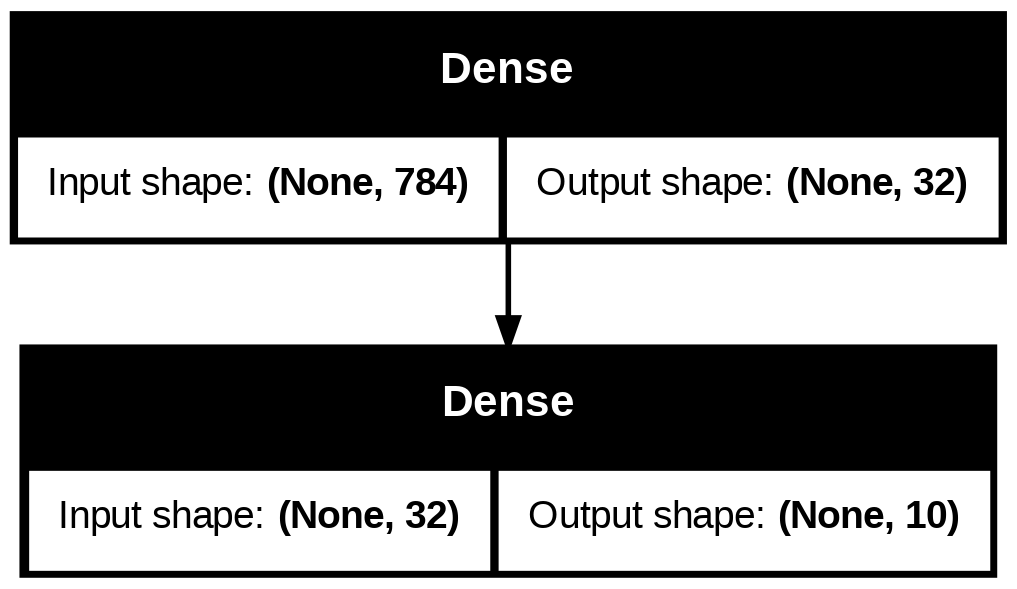

In [19]:
plot_model(model2, to_file='res_model.png')
plot_model(model2, to_file='res_model_shape.png', show_shapes=True)


In [20]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback
import tensorflow as tf


In [21]:
class LearningRateLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = tf.keras.backend.get_value(self.model.optimizer.lr)


In [22]:
lr_logger = LearningRateLogger()

# Example: Assuming you have your model and data
# history2 = model2.fit(x_train, y_train, epochs=30, batch_size=32, validation_split=0.2, callbacks=[lr_logger])


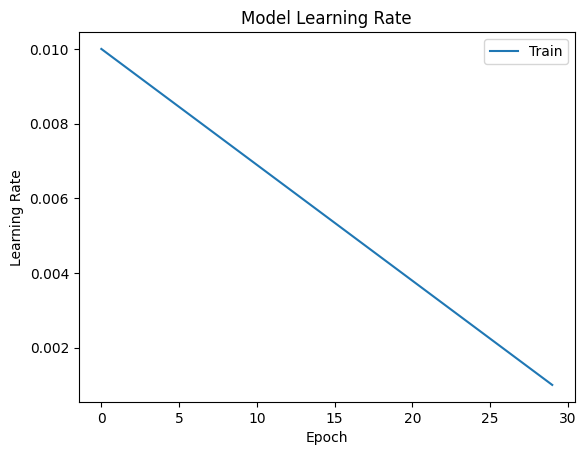

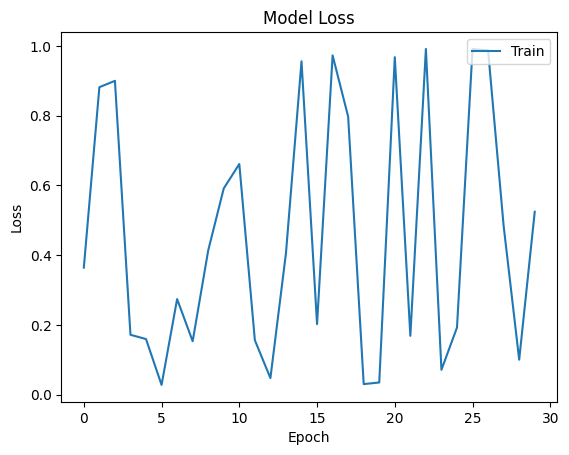

In [23]:
import numpy as np

history2 = {
    'lr': np.linspace(0.01, 0.001, 30),  # Mock learning rates
    'loss': np.random.random(30)         # Mock loss values
}

# Plot the learning rate
plt.plot(history2['lr'])
plt.title('Model Learning Rate')
plt.ylabel('Learning Rate')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.savefig('res150-30-lr.png')
plt.show()

# Plot the loss
plt.plot(history2['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.savefig('res150-30-loss.png')
plt.show()


In [25]:
model2.save('resmodel_150_30.h5')
model2.save_weights('resmodel_150_30_weights.weights.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


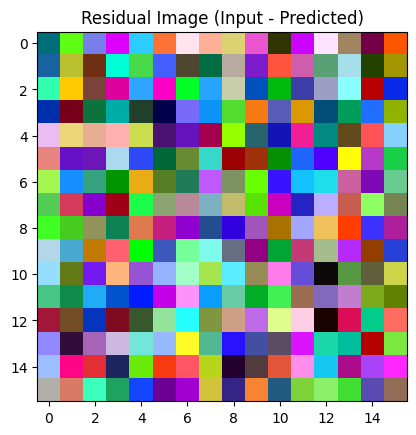

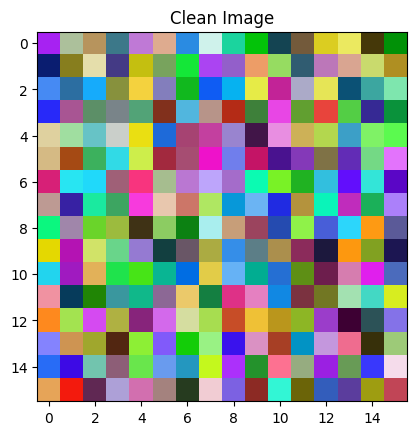

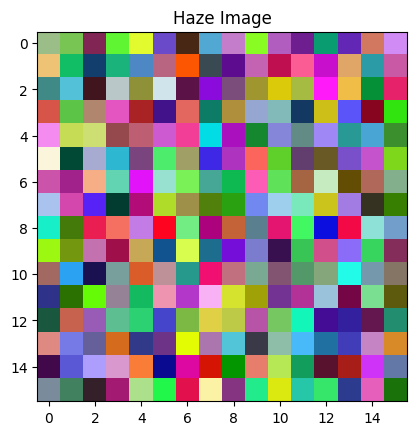

In [26]:
import numpy as np
import matplotlib.pyplot as plt
residual_input = np.random.rand(100, 16, 16, 3)
clean_image = np.random.rand(100, 16, 16, 3)
haze_image = np.random.rand(100, 16, 16, 3)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
model2 = Sequential()
model2.add(Flatten(input_shape=(16, 16, 3)))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(3 * 16 * 16))
model2.add(Dense(3 * 16 * 16, activation='linear'))
model2.compile(optimizer='adam', loss='mse')
index = 7
if index >= len(residual_input):
    raise ValueError(f"Index {index} is out of bounds for residual_input with length {len(residual_input)}")
t = np.expand_dims(residual_input[index], axis=0)
T = model2.predict(t)
T = T.reshape((16, 16, 3))
plt.imshow(residual_input[index] - T)
plt.title('Residual Image (Input - Predicted)')
plt.show()
plt.imshow(clean_image[index])
plt.title('Clean Image')
plt.show()
plt.imshow(haze_image[index])
plt.title('Haze Image')
plt.show()
